In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
import statistics as stat
import pickle

In [3]:
neur = sc.read_h5ad('../data/neur.h5ad')
neur = neur[:,neur.var['Selected']==1]
neur.obs['dpt_pseudotime'] = neur.obs['dpt_pseudotime']/max(neur.obs['dpt_pseudotime'])

Trying to set attribute `.obs` of view, copying.


In [4]:
max(neur.obs['dpt_pseudotime'])

1.0

Define pseudotime decile bins

In [6]:
_, nG = neur.X.shape
nC = 10
counts = neur.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = 1/nC
for c in range(nC):
    neur_c = neur[(c*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] < (c+1)*bin_w)]
    exp_c = csr_matrix.sum(neur_c.X, 0)/csr_matrix.sum(neur_c.X)
    exp_c = np.log(10**4 * exp_c + 1)
    numcells[c] = neur_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])

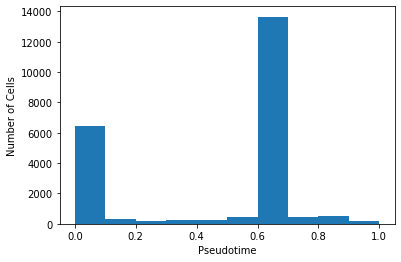

In [7]:
pl.hist(neur.obs['dpt_pseudotime'], bins=10)
pl.xlabel("Pseudotime")
pl.ylabel("Number of Cells")
pl.show()

In [8]:
def quantile_normalize(data):
    featranks = np.zeros(data.shape, dtype=int)
    normdata = np.zeros(data.shape)
    for i in range(len(featranks)):
        featranks[i,:] = rankdata(data[i,:])
    featranks -= 1
    normexp = np.average(np.sort(data, axis=1), axis=0)
    for i in range(data.shape[0]):
        for g in range(data.shape[1]):
            normdata[i,g] = normexp[featranks[i,g]]
    return(normdata)
# Ynorm = quantile_normalize(Y)
Ynorm = Y

Center and scale

In [11]:
for g in range(Ynorm.shape[1]):
    if stat.stdev(Ynorm[:,g])==0:
        Ynorm[:,g] = np.zeros(10)
    else:
        Ynorm[:,g] = (Ynorm[:,g]-np.mean(Ynorm[:,g]))/stat.stdev(Ynorm[:,g])
Yflat = Ynorm.flatten()

In [12]:
genedict = {neur.var.index[i]:i for i in range(len(neur.var.index))}

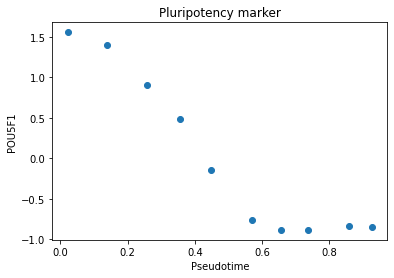

In [13]:
pl.plot(t, Ynorm[:,genedict["POU5F1"]], "o")
pl.ylabel("POU5F1")
pl.xlabel("Pseudotime")
pl.title("Pluripotency marker")
pl.show()

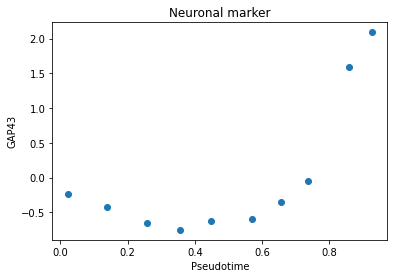

In [14]:
pl.plot(t, Ynorm[:,genedict["GAP43"]], "o")
pl.ylabel("GAP43")
pl.xlabel("Pseudotime")
pl.title("Neuronal marker")
pl.show()

In [15]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

In [16]:
np.savetxt( "../data/neur.X.txt", X)
np.savetxt("../data/neur.Y.txt", Yflat)

In [17]:
with open("../data/genedict.neur.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()